In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import global_max_pool, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch, DataLoader
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
train_data = torch.load("data/MNISTSuperpixels_train_data.pt")
test_data = torch.load("data/MNISTSuperpixels_test_data.pt")

print(len(train_data))
print(len(test_data))

print(train_data[0])
print(test_data[0])

NUM_NODE_FEATURES = 3
NUM_CLASSES = 10

60000
10000
Data(edge_index=[2, 472], label=5, pos=[77, 2], x=[77, 3])
Data(edge_index=[2, 488], label=7, pos=[81, 2], x=[81, 3])


In [3]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [4]:
t = torch.tensor(([1,2,3,4,5],[1,2,3,4,5]))
print(t)
print(t.shape)
print(type(t.shape))
print(list(t.shape))
print(t.tolist())

tensor([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5]])
torch.Size([2, 5])
<class 'torch.Size'>
[2, 5]
[[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]


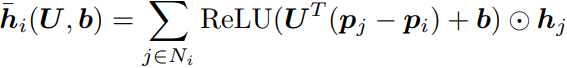

In [5]:
class SGCNConv(MessagePassing):
    
    def __init__(self, in_channels, out_channels, dim):
        super(SGCNConv, self).__init__(aggr='add')
        self.out_channels = out_channels
        
        self.linear = torch.nn.Linear(dim, in_channels * out_channels)
        self.linear_out = torch.nn.Linear(in_channels * out_channels, out_channels)

    def forward(self, x, edge_index, pos):

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, pos=pos)

    def message(self, x_j, pos_i, pos_j):
        pos_diff = (pos_j - pos_i).abs()
        
        w = self.linear(pos_diff)
        w = F.relu(w)
        
        num_nodes, num_of_features = list(x_j.shape)
        num_nodes, size = list(w.shape)
        
        tmp = w.view(num_of_features, self.out_channels, num_nodes)
        x = (tmp * x_j.T.unsqueeze(1)).reshape(num_nodes, size)
        x = self.linear_out(x)
        
        return x

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SGCNConv(NUM_NODE_FEATURES, 8, dim=2)
        self.conv2 = SGCNConv(8, 8, dim=2)
        self.conv3 = SGCNConv(8, 32, dim=2)

        self.linear = nn.Linear(32, NUM_CLASSES)
        
    def forward(self, data):
        x, edge_index, pos = data.x, data.edge_index, data.pos

        x = self.conv1(x, edge_index, pos)
        x = F.relu(x)
        x = self.conv2(x, edge_index, pos)
        x = F.relu(x)
        x = self.conv3(x, edge_index, pos)
        
#         x = global_add_pool(x, data.batch)
        x = global_mean_pool(x, data.batch)
#         x = global_max_pool(x, data.batch)
        
        x = self.linear(x)

        return F.log_softmax(x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
model = Net()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def evaluate():
    model.eval()
    acc = 0
    loss = 0
    for data in test_loader:
        
        data = data.to(device)
        out = model(data) 
        _, predicts = out.max(dim=1)
        target = torch.tensor(data.label).to(device)
        loss += F.nll_loss(out, target).item()
        correct = predicts.eq(target).sum().item()
        acc += correct
        
    acc =  acc * 100 / len(test_data)
    loss /= len(test_data)
    return acc, loss

In [10]:
acc, loss = evaluate()
print(acc)
print(loss)

C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


11.48
0.984775772857666


In [11]:
rotation_0 = T.RandomRotate(degrees=180, axis=0)
rotation_1 = T.RandomRotate(degrees=180, axis=1)
rotation_2 = T.RandomRotate(degrees=180, axis=2)

In [12]:
train_loss_hist = []
test_loss_hist = []
acc_hist = []

for i in range(100):
    
    model.train()
    total_loss = 0
    
    for data in train_loader:     
        
        data = data.to(device)
        out = model(data)
        target = torch.tensor(data.label).to(device)
    
        optimizer.zero_grad()
        loss = F.nll_loss(out, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_data) 
    acc, test_loss = evaluate()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    acc_hist.append(acc)
    
    print(f"Ep: {i}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Acc: {acc:.2f}%")

C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Ep: 0, Train loss: 0.0751, Test loss: 0.0680, Acc: 21.02%
Ep: 1, Train loss: 0.0638, Test loss: 0.0641, Acc: 23.31%
Ep: 2, Train loss: 0.0627, Test loss: 0.0624, Acc: 24.79%
Ep: 3, Train loss: 0.0623, Test loss: 0.0616, Acc: 26.35%
Ep: 4, Train loss: 0.0619, Test loss: 0.0639, Acc: 24.22%
Ep: 5, Train loss: 0.0617, Test loss: 0.0617, Acc: 25.69%
Ep: 6, Train loss: 0.0615, Test loss: 0.0608, Acc: 27.33%
Ep: 7, Train loss: 0.0612, Test loss: 0.0610, Acc: 26.41%
Ep: 8, Train loss: 0.0611, Test loss: 0.0609, Acc: 26.73%
Ep: 9, Train loss: 0.0610, Test loss: 0.0622, Acc: 26.29%
Ep: 10, Train loss: 0.0608, Test loss: 0.0605, Acc: 27.28%
Ep: 11, Train loss: 0.0608, Test loss: 0.0604, Acc: 27.62%
Ep: 12, Train loss: 0.0608, Test loss: 0.0608, Acc: 26.49%
Ep: 13, Train loss: 0.0607, Test loss: 0.0622, Acc: 26.69%
Ep: 14, Train loss: 0.0606, Test loss: 0.0611, Acc: 26.99%


KeyboardInterrupt: 